In [1]:
# Setup 
import time
import numpy as np
import matplotlib.pyplot as plt
import generate_image_files as gif
from cs231n.classifiers.fc_net import *
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load images
data = gif.get_data()
               
# Normalize the data: subtract the mean image
mean_image = np.mean(data['X_train'])
data['X_train'] -= mean_image
data['X_val'] -= mean_image
data['X_test'] -= mean_image

# Print data size and shape
for k, v in data.iteritems():
  print '%s: ' % k, v.shape


data #100, emotion class:3, category:Training

data #200, emotion class:5, category:Training

data #300, emotion class:1, category:Training

data #400, emotion class:6, category:Training

data #500, emotion class:0, category:Training

data #600, emotion class:2, category:Training

data #700, emotion class:6, category:Training

data #800, emotion class:2, category:Training

data #900, emotion class:4, category:Training

data #1000, emotion class:6, category:Training

data #1100, emotion class:3, category:Training

data #1200, emotion class:6, category:Training

data #1300, emotion class:0, category:Training

data #1400, emotion class:5, category:Training

data #1500, emotion class:3, category:Training

data #1600, emotion class:2, category:Training

data #1700, emotion class:3, category:Training

data #1800, emotion class:2, category:Training

data #1900, emotion class:0, category:Training

data #2000, emotion class:5, category:Training

data #2100, emotion class:2, category:Training

d

In [23]:
# Train a convnet using raw pixel features
from cs231n.classifiers.convnet import *
from cs231n.layers import *
from cs231n.fast_layers import *

# Normalize the data: subtract the mean image
mean_image = np.mean(data['X_train'])
data['X_train'] -= mean_image
data['X_val'] -= mean_image
data['X_test'] -= mean_image

data['X_train'] = data['X_train'].reshape([data['X_train'].shape[0], 48, 48, 1]).transpose(0,3,1,2)
data['X_val'] = data['X_val'].reshape([data['X_val'].shape[0], 48, 48, 1]).transpose(0,3,1,2)
data['X_test'] = data['X_test'].reshape([data['X_test'].shape[0], 48, 48, 1]).transpose(0,3,1,2)

data['y_train'] = data['y_train'].astype(np.int64)
data['y_val'] = data['y_val'].astype(np.int64)
data['y_test'] = data['y_test'].astype(np.int64)


convlayer_params = {'convlayer_num': 2 ,'num_filters': [32, 32], 'filter_size': 3,
                   'stride': 1, 'pad':(3 - 1) / 2, 's_batch_norm': False,
                   'pool_dim': 2, 'pool_stride': 2}
affinelayer_params = {'afflayer_num': 1, 'hidden_dim': [50], 'batch_norm': False,
                      'dropout': False}

print 'check initial loss:'
###Loss check###
weight_scales = 5e-2
model = MyFullyConvNet(convlayer_params, affinelayer_params, weight_scale=weight_scales, reg=0.0)

X = np.random.randn(100, 1, 48, 48)
y = np.random.randint(7, size=100)
loss, _ = model.loss(X, y)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check: Initial loss (no regularization): ', loss

# Sanity check: Loss should increase when we add regularization
model = MyFullyConvNet(convlayer_params, affinelayer_params, weight_scale=weight_scales, reg=0.01)
loss, _ = model.loss(X, y)
print 'Sanity check: Initial loss (with regularization): ', loss
print ' '
print 'check gradient:'

###Gradient check using numerical gradient computatation###
num_inputs = 2
input_shape = (1, 16, 16)
reg = 0.0
num_classes = 7
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

convlayer_params = {'convlayer_num': 2 ,'num_filters': [3, 3], 'filter_size': 3,
                   'stride': 1, 'pad':(3 - 1) / 2, 's_batch_norm': False,
                   'pool_dim': 2, 'pool_stride': 2}

affinelayer_params = {'afflayer_num': 1, 'hidden_dim': [7], 'batch_norm': False,
                      'dropout': False}

model = MyFullyConvNet(convlayer_params, affinelayer_params, weight_scale=weight_scales,
                       reg=reg, input_dim=input_shape,
                       num_classes=num_classes, dtype=np.float64)


loss, grads = model.loss(X, y)
for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[name])
    print '%s max relative error: %e' % (name, rel_error(param_grad_num, grads[name]))

print ' '
print 'Over fit a small data:'
###Overfit small data###
num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train,],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

convlayer_params = {'convlayer_num': 2 ,'num_filters': [32, 32], 'filter_size': 3,
                   'stride': 1, 'pad':(3 - 1) / 2, 's_batch_norm': False,
                   'pool_dim': 2, 'pool_stride': 2}
affinelayer_params = {'afflayer_num': 1, 'hidden_dim': [50], 'batch_norm': False,
                      'dropout': False}

model = MyFullyConvNet(convlayer_params, affinelayer_params, weight_scale=weight_scales, reg=0.0)

solver = Solver(model, small_data,
                num_epochs=20, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

print " "
print "Let's train the real Net using Kaggle data:"
###AND FINALLY TRAIN WITH ALL CIFAR-10 DATA!###
#Below you can find the best model parameters that I found to train the net.#
# The accuracies as well as the loss and accuracy histories are plotted in the next box.#

convlayer_params = {'convlayer_num': 2 ,'num_filters': [32, 64], 'filter_size': 3,
                   'stride': 1, 'pad':(3 - 1) / 2, 's_batch_norm': False,
                   'pool_dim': 2, 'pool_stride': 2}
affinelayer_params = {'afflayer_num': 1, 'hidden_dim': [100], 'batch_norm': False,
                      'dropout': False}

reg = 0.0001
weight_scales = 5e-2
learn_rate = 1e-3
model = MyFullyConvNet(convlayer_params, affinelayer_params, weight_scale=weight_scales, reg=reg)

solver = Solver(model, data,
                num_epochs=20, batch_size=100,
                update_rule='adam',
                optim_config={
                'learning_rate': learn_rate,},
                  verbose=True, print_every=100)
solver.train()


check initial loss:
Sanity check: Initial loss (no regularization):  2.37978912354
Sanity check: Initial loss (with regularization):  5.3088249895
 
check gradient:
aff_W1 max relative error: 2.409325e-05
aff_W2 max relative error: 2.487378e-07
aff_b1 max relative error: 1.066357e-08
aff_b2 max relative error: 3.705190e-10
conv_W1 max relative error: 2.780355e-06
conv_W2 max relative error: 2.680008e-06
conv_b1 max relative error: 2.519349e-08
conv_b2 max relative error: 4.119094e-09
 
Over fit a small data:
(Iteration 1 / 40) loss: 6.967020
(Epoch 0 / 20) train acc: 0.150000; val_acc: 0.164948
(Iteration 2 / 40) loss: 5.556999
(Epoch 1 / 20) train acc: 0.170000; val_acc: 0.177208
(Iteration 3 / 40) loss: 4.002658
(Iteration 4 / 40) loss: 2.630510
(Epoch 2 / 20) train acc: 0.260000; val_acc: 0.166063
(Iteration 5 / 40) loss: 2.589495
(Iteration 6 / 40) loss: 2.017558
(Epoch 3 / 20) train acc: 0.310000; val_acc: 0.186960
(Iteration 7 / 40) loss: 1.750187
(Iteration 8 / 40) loss: 2.01928

cs231n/layers.py:728: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


Best training accuracy: 0.973
Validation set accuracy:  0.500975202006
Test set accuracy:  0.505154639175


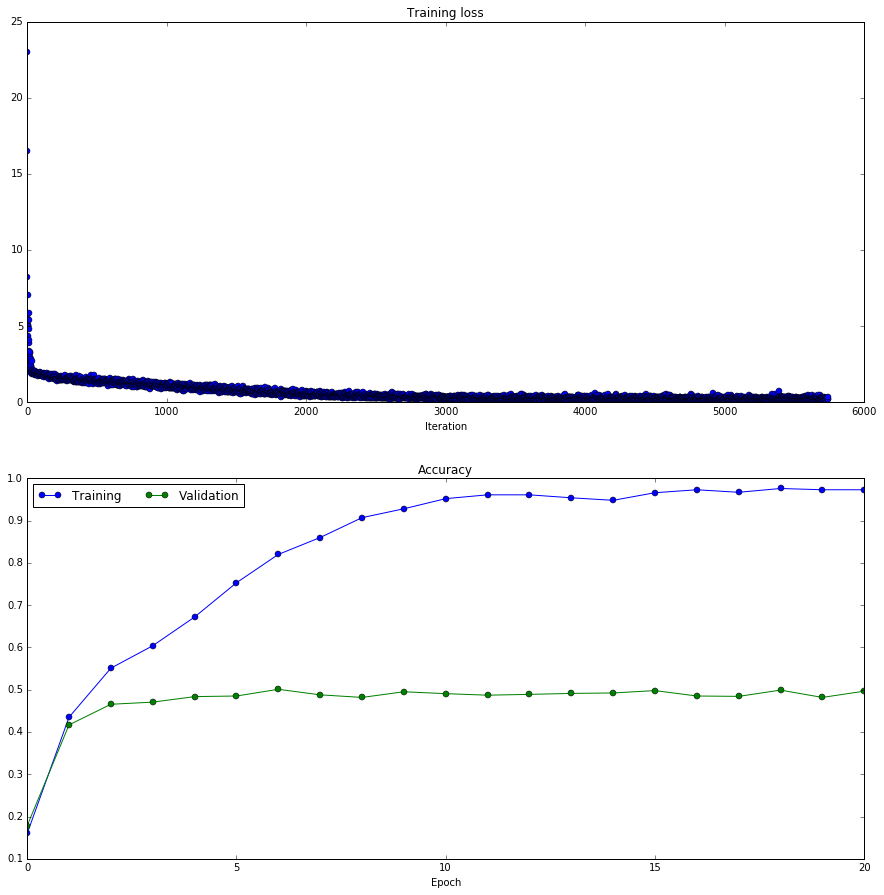

In [33]:
# print best training accuracy and predict test set labels
print 'Best training accuracy: 0.973' 
model.params = solver.best_params
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print 'Validation set accuracy: ', (y_val_pred == data['y_val']).mean()
print 'Test set accuracy: ', (y_test_pred == data['y_test']).mean()

# plot loss history and accuracies
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o', label='Training')
plt.plot(solver.val_acc_history, '-o', label='Validation')

for i in [1, 2]:
  plt.subplot(2, 1, i)
  plt.legend(loc='upper left', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()


In [26]:
# generate HOG features
from cs231n.features import *

# Revert data to their original status
X_train = data['X_train'] + mean_image
X_val = data['X_val'] + mean_image
X_test = data['X_test'] + mean_image

feature_fns = [hog_feature]
X_train_feats = extract_features(data['X_train'], feature_fns, verbose=True)
X_val_feats = extract_features(data['X_val'], feature_fns)
X_test_feats = extract_features(data['X_test'], feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 28709 images
Done extracting features for 2000 / 28709 images
Done extracting features for 3000 / 28709 images
Done extracting features for 4000 / 28709 images
Done extracting features for 5000 / 28709 images
Done extracting features for 6000 / 28709 images
Done extracting features for 7000 / 28709 images
Done extracting features for 8000 / 28709 images
Done extracting features for 9000 / 28709 images
Done extracting features for 10000 / 28709 images
Done extracting features for 11000 / 28709 images
Done extracting features for 12000 / 28709 images
Done extracting features for 13000 / 28709 images
Done extracting features for 14000 / 28709 images
Done extracting features for 15000 / 28709 images
Done extracting features for 16000 / 28709 images
Done extracting features for 17000 / 28709 images
Done extracting features for 18000 / 28709 images
Done extracting features for 19000 / 28709 images
Done extracting features for 20000 / 28709 images
Done extr

In [27]:
print X_train_feats.shape

(28709, 325)
